# Implémentez un modèle de scoring


## Plan de l'Etude :

<a href="#C0">C0. Description de la problematique et Objectif de la mission</a>

<a href="#C1">C1. Recuperation des donnees</a>

<a href='#C2'>C2. Apercu des donnees</a>

<a href='#C3'>C3. Exploration des donnees (EDA)</a>

<a href='#C4'>C4. Feature Enginearing</a>

<a href='#C5'>C5. Modelisation</a>
- <a href='#C5.1'>C5.1. Modelisation avec PYCARET(SMOTE)</a>
- <a href='#C5.2'>C5.2. Modelisation - RandomSearchCV - pipeline avec SMOTE</a>
    - <a href='#C5.2.1'>C5.2.1. Pre-processing</a>
    - <a href='#C5.2.2'>C5.2.2. Modelisation avec SMOTE - imbalanced make pipeline</a>
    - <a href='#C5.2.3'>C5.2.3. Performance des differents classifieurs</a>
    - <a href='#C5.2.4'>C5.2.4. Matrices de confusions et choix du meilleur modele</a>
- <a href='#C5.3'>C5.3. Threshold-Moving for Imbalanced Classification/a>

<a href='#C6'>C6. Interpretation : SHAP (SHapley Additive exPlanations)</a>

# <a name="C0">C0. Description de la problematique et Objectif de la mission</a>

## Objectif

La société financière **Prêt à dépenser**,  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de **scoring crédit** pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un **dashboard interactif** pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

## Mission

1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.



## Spécifications du dashboard

Le dashboard interactif devra contenir au minimum les fonctionnalités suivantes :

- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

 # <a id='C1'>C1. Recuperation des donnees</a>

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# <a id='C2'>C2. Aperçu des données</a>


In [2]:
# List files available
path = "../Projet7/Data/"
print(os.listdir(path))

['.ipynb_checkpoints', 'application_test.csv', 'application_test_domain.csv', 'application_test_domain_1000.csv', 'application_train.csv', 'application_train_domain.csv', 'best_model_optim_threshold.pkl', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'df_Client_Info.csv', 'df_test_neighbors.csv', 'df_X_test.csv', 'df_X_test_1000.csv', 'df_X_train.csv', 'expected_value.pkl', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'Projet+Mise+en+prod+-+home-credit-default-risk.zip', 'sample_submission.csv', 'shap_values.pkl']


In [3]:
# Training data
application_train = pd.read_csv(path + 'application_train.csv')
print('Training data shape: ', application_train.shape)
application_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

## Pour le besoin de l'interpretation SHAP a la fin de cette etude nous avons besoin de la test DATA

In [4]:
# Test data
application_test = pd.read_csv(path + 'application_test.csv')
print('Test data shape: ', application_test.shape)
application_test.head()

Test data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [5]:
# Feature descriptions
data_desc = pd.read_csv(path + 'HomeCredit_columns_description.csv',encoding_errors='ignore')
print('Description data shape: ', data_desc.shape)
data_desc.head()

Description data shape:  (219, 5)


Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [6]:
data_desc[(data_desc['Table']=='application_{train|test}.csv')  & (data_desc['Row']=='TARGET')]['Description']

1    Target variable (1 - client with payment diffi...
Name: Description, dtype: object

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

# <a id='C3'>3. Exploration des donnees (EDA)</a>



## Distribution de la colonne Target

TARGET : prends 2 valeurs possibles :
- 0 si le prêt a été remboursé à temps
- 1 si le client a eu des difficultés de paiement.

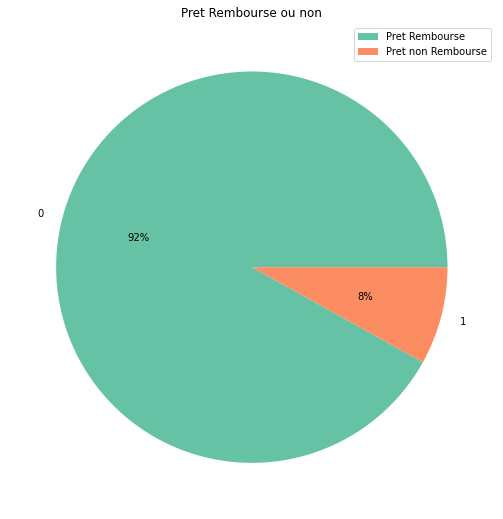

In [7]:
plt.figure(figsize=(16,9))

temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

data = df['values']
labels = df['labels']
colors = sns.color_palette('Set2')

plt.pie(data, labels=labels,colors = colors, autopct = '%0.0f%%')

plt.title('Pret Rembourse ou non')
plt.legend(["Pret Rembourse", "Pret non Rembourse"])

plt.show()

D'après ces informations, nous voyons qu'il s'agit d'un problème de classe déséquilibré (imbalance-problem).

Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés.

## Valeurs manquantes

Ensuite, nous pouvons regarder le nombre et le pourcentage de valeurs manquantes dans chaque colonne. 

In [8]:
# Fonction pour calculer le nombre de valeurs manuquantes par colonne 
def missing_values_table(df):
        # Total valeurs manquantes
        mis_val = df.isnull().sum()
        
        # Pourcentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # On cree une table avec le resulat
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # On renomme les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs Manquantes', 1 : '% of Total Valeurs'})
        
        # Trier la table en descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Valeurs', ascending=False).round(1)
        
        # Print de quelques informations de compte-rendu
        print ("Ce dataframe a " + str(df.shape[1]) + " colonnes.\n"      
            "Il ya  " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes qui ont des valeurs manquantes.")
        
        # Return du dataframe des valeurs manquantes
        return mis_val_table_ren_columns

In [9]:
# Statistiques valeurs manquantes
missing_values = missing_values_table(application_train)
missing_values.head(20)

Ce dataframe a 122 colonnes.
Il ya  67 colonnes qui ont des valeurs manquantes.


Valeurs Manquantes  % of Total Valeurs
COMMONAREA_MEDI                       214865                69.9
COMMONAREA_AVG                        214865                69.9
COMMONAREA_MODE                       214865                69.9
NONLIVINGAPARTMENTS_MEDI              213514                69.4
NONLIVINGAPARTMENTS_MODE              213514                69.4
NONLIVINGAPARTMENTS_AVG               213514                69.4
FONDKAPREMONT_MODE                    210295                68.4
LIVINGAPARTMENTS_MODE                 210199                68.4
LIVINGAPARTMENTS_MEDI                 210199                68.4
LIVINGAPARTMENTS_AVG                  210199                68.4
FLOORSMIN_MODE                        208642                67.8
FLOORSMIN_MEDI                        208642                67.8
FLOORSMIN_AVG                         208642                67.8
YEARS_BUILD_MODE                      204488                66.5
YEARS_BUILD_MEDI                      204488                66.5
YEARS_BUILD_AVG                       204488                66.5
OWN_CAR_AGE                           202929                66.0
LANDAREA_AVG                          182590                59.4
LANDAREA_MEDI                         182590                59.4
LANDAREA_MODE                         182590                59.4

Lorsque viendra le temps de construire nos modèles d'apprentissage automatique, nous devrons remplir ces valeurs manquantes par imputation. Nous avons choisi d'utiliser la classe SimpleImputer de scikit-learn.

Neanmoins certaines valeurs manquantes importantes doivent etre traites avant. Comme le gender des clienst (M ou F)



In [10]:
missing_values.index

Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'LANDAREA_MEDI',
       'LANDAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI',
       'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_MEDI',
       'ELEVATORS_MODE', 'ELEVATORS_AVG', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG',
       'ENTRANCES_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'LIVINGAREA_MEDI',
       'LIVINGAREA_MODE', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE', 'FLOORSMAX_MEDI',
       'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_AVG'

In [11]:
application_train[application_train['CODE_GENDER']=='XNA']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
35657       141289       0    Revolving loans         XNA            Y   
38566       144669       0    Revolving loans         XNA            N   
83382       196708       0    Revolving loans         XNA            N   
189640      319880       0    Revolving loans         XNA            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
35657                Y             0          207000.0    382500.0   
38566                Y             2          157500.0    270000.0   
83382                Y             1          135000.0    405000.0   
189640               Y             0          247500.0    540000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
35657       19125.0  ...                 0                0                0   
38566       13500.0  ...                 0                0                0   
83382       20250.0  ...                 0                0                0   
189640      27000.0  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
35657                 0                        0.0                       0.0   
38566                 0                        0.0                       0.0   
83382                 0                        0.0                       0.0   
189640                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
35657                          0.0                        0.0   
38566                          0.0                        3.0   
83382                          0.0                        0.0   
189640                         0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
35657                         0.0                         1.0  
38566                         0.0                         4.0  
83382                         0.0                         3.0  
189640                        1.0                         6.0  

[4 rows x 122 columns]

## Types des colonnes

Examinons le nombre de colonnes de chaque type de données. `int64` et `float64` sont des variables numériques qui peuvent être discrètes ou continues. Les colonnes `object` contiennent des chaînes et sont des variables catégorielles.

In [12]:
# Nombre de chaque type de colonne
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Examinons maintenant le nombre d'entrées uniques dans chacune des colonnes "object" (catégorielles).

In [13]:
# Nombre de classes uniques dans chaque colonne 'object'
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques.

## Anomalies

Une façon de prendre en charge quantitativement les anomalies consiste à examiner les statistiques d'une colonne à l'aide de la méthode "describe". Les nombres dans la colonne "DAYS_BIRTH" sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année :

In [14]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure. Qu'en est-il de 'DAYS_EMPLOYED'?

In [15]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

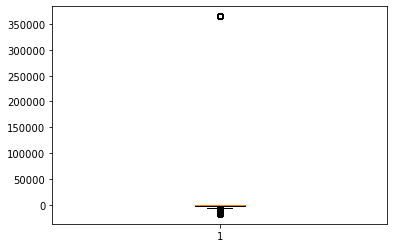

In [16]:
plt.boxplot(application_train['DAYS_EMPLOYED'])
plt.show()

Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans !

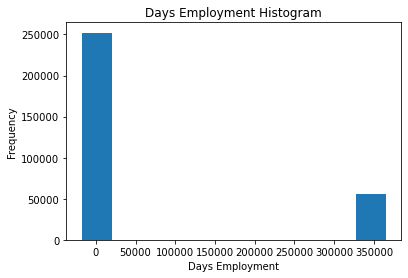

In [17]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Juste par curiosité, sous-divisons les clients anormaux et voyons s'ils ont tendance à avoir des taux de défaut plus élevés ou plus faibles que le reste des clients.

In [18]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('Les non-anomalies ont %0.2f%% default de paiement' % (100 * non_anom['TARGET'].mean()))
print('Les anomalies ont %0.2f%% default de paiment' % (100 * anom['TARGET'].mean()))
print('Il y a %d jours d''emplois anormaux' % len(anom))

Les non-anomalies ont 8.66% default de paiement
Les anomalies ont 5.40% default de paiment
Il y a 55374 jours demplois anormaux


Eh bien c'est extrêmement intéressant ! Il s'avère que les anomalies ont un taux de défaut plus faible.

La gestion des anomalies dépend de la situation exacte, sans règles définies. L'une des approches les plus sûres consiste simplement à définir les anomalies sur une valeur manquante, puis à les faire remplir (à l'aide de l'imputation SimpleImputer) avant l'apprentissage automatique. Dans ce cas, puisque toutes les anomalies ont exactement la même valeur, nous voulons les remplir avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, nous voulons donc indiquer au modèle d'apprentissage automatique si nous avons effectivement rempli ces valeurs. Comme solution, nous allons remplir les valeurs anormales sans un nombre (`np.nan`) puis créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.



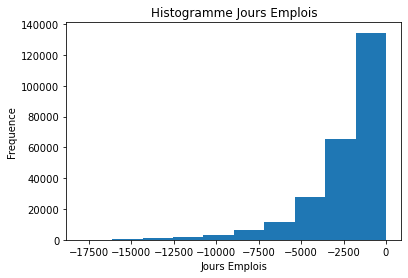

In [19]:
# Creer une colonne de top anomalie
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Remplacer les anomalies par nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

application_train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme Jours Emplois');
plt.xlabel('Jours Emplois');
plt.ylabel('Frequence');

La distribution semble être beaucoup plus conforme à ce à quoi nous nous attendions, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (car nous devrons remplir les nans avec une certaine valeur, probablement la médiane de la colonne). Les autres colonnes avec `DAYS` dans le cadre de données semblent correspondre à ce que nous attendons sans valeurs aberrantes évidentes.


### Correlations

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, continuons avec l'EDA. Une façon d'essayer de comprendre les données consiste à rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible en utilisant la méthode de dataframe `.corr`.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données. Certaines interprétations générales de la valeur absolue du coefficient de corrélation sont :


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [20]:
# Trouver les correlations avec la TARGET et trier
correlations = application_train.corr()['TARGET'].sort_values()

# Afficher les correlations
print('Correlations les plus positives:\n', correlations.tail(15))
print('\nCorrelations les plus negatives:\n', correlations.head(15))

Correlations les plus positives:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Correlations les plus negatives:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              

Examinons quelques-unes des corrélations les plus significatives : le "DAYS_BIRTH" est la corrélation la plus positive. (sauf pour `TARGET` car la corrélation d'une variable avec elle-même vaut toujours 1 !) En regardant la documentation, `DAYS_BIRTH` est l'âge en jours du client au moment du prêt en jours négatifs (quelle qu'en soit la raison !) . La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie qu'à mesure que le client vieillit, il est moins susceptible de faire défaut sur son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique, puis la corrélation sera négative.

### Effet de l'age sur le remboursement

In [21]:
# 
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.07823930830982712

À mesure que le client vieillit, il existe une relation linéaire négative avec la cible, ce qui signifie qu'à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent.

Commençons à regarder cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. Nous mettrons l'axe des x en années pour rendre l'affichage un peu plus compréhensible.

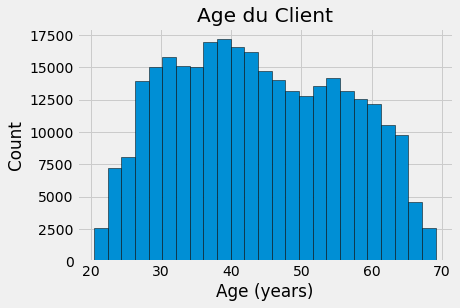

In [22]:
# Style des plots
plt.style.use('fivethirtyeight')

# Plot la distribution des ages en annees
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age du Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous dit pas grand-chose d'autre que le fait qu'il n'y a pas de valeurs aberrantes car tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite créer un graphique KDE (**KDE : A kernel density estimate plot**) coloré par la valeur de la cible. Un graphique KDE montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement un gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le seaborn `kdeplot` pour ce graphique.

Text(0, 0.5, 'Densite')

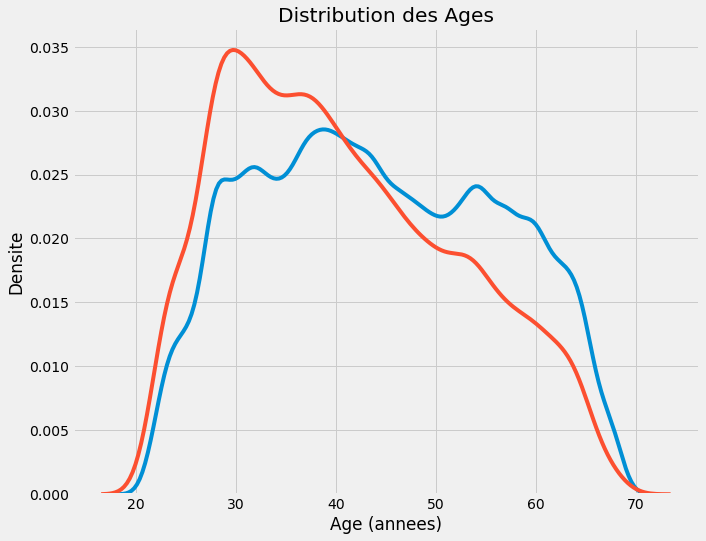

In [23]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (annees)'); plt.ylabel('Density'); plt.title('Distribution des Ages');
plt.ylabel('Densite')

La courbe TARGET == 1 s'incline vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Regardons cette relation sous un autre angle : incapacité moyenne à rembourser les crédits par tranche d'âge.

Pour faire ce graphique, nous avons d'abord "découpé" la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque bac, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [24]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [25]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

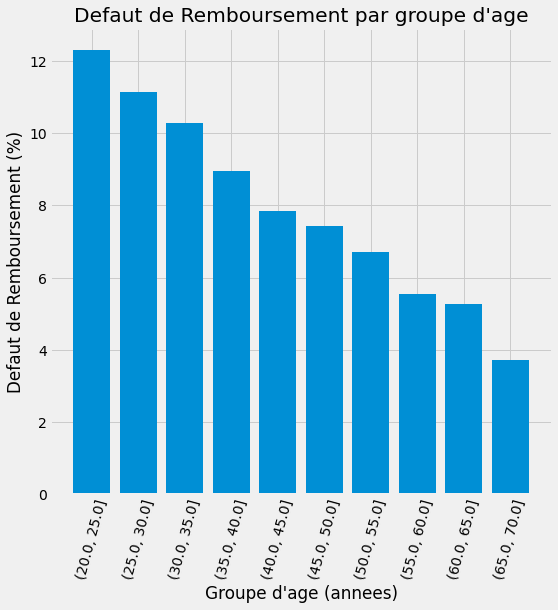

In [26]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel("Groupe d'age (annees)"); plt.ylabel('Defaut de Remboursement (%)')
plt.title("Defaut de Remboursement par groupe d'age");

Il y a une tendance claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux d'impayés est supérieur à 10 % pour les trois tranches d'âge les plus jeunes et inférieur à 5 % pour la tranche d'âge la plus élevée.

Il s'agit d'informations qui pourraient être directement utilisées par la banque : étant donné que les clients plus jeunes sont moins susceptibles de rembourser le prêt, il faudrait peut-être leur fournir davantage de conseils ou de conseils de planification financière. Cela ne signifie pas que la banque devrait discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour aider les jeunes clients à payer à temps.

### Sources Externes

Les 3 variables avec les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2` et `EXT_SOURCE_3`.
Selon la documentation, ces fonctionnalités représentent un "score normalisé à partir d'une source de données externe". Je ne suis pas sûr de ce que cela signifie exactement, mais il peut s'agir d'une sorte de cote de crédit cumulative établie à l'aide de nombreuses sources de données.

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

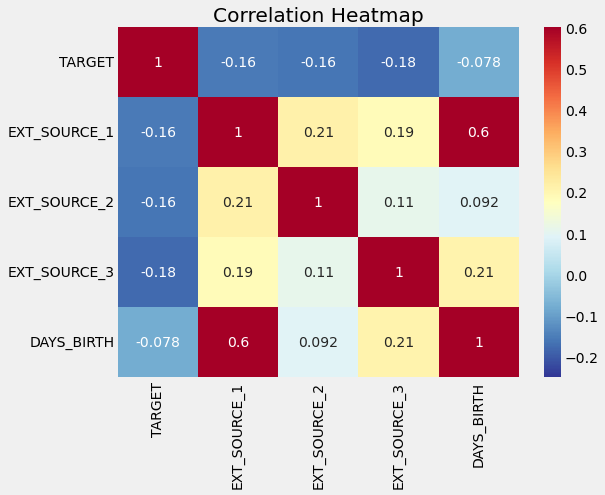

In [28]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques `EXT_SOURCE` ont des corrélations négatives avec la cible, ce qui indique qu'à mesure que la valeur de `EXT_SOURCE` augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_1` indiquant que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

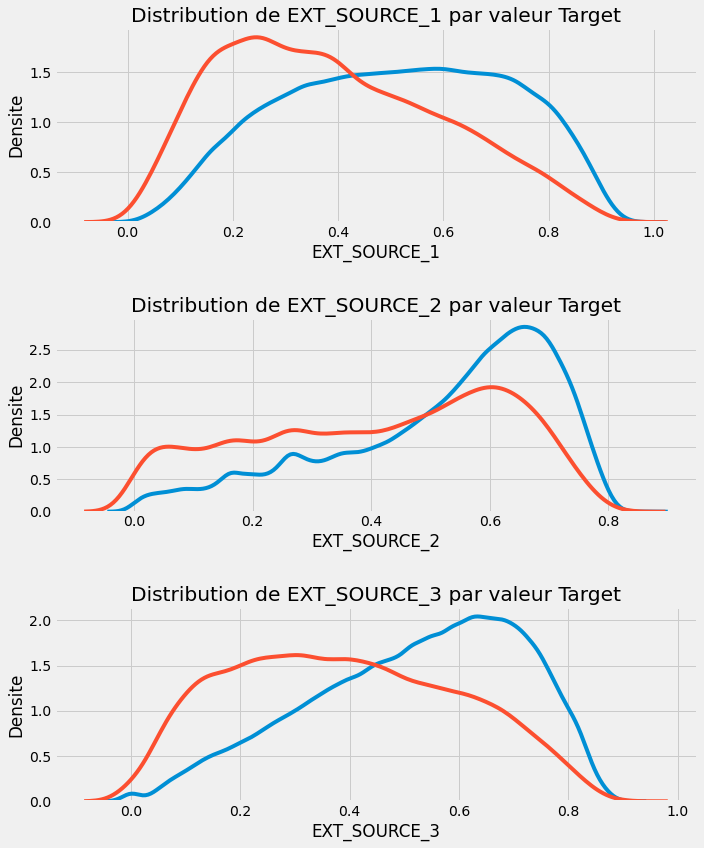

In [29]:
plt.figure(figsize = (10, 12))

# iteration sur les sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot prets rembourses
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot prets non rembourses
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label des plots
    plt.title('Distribution de %s par valeur Target' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densite');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait elles sont toutes considérées comme très faibles, mais ces variables seront tout de même utiles pour un machine learning modèle pour prédire si un demandeur remboursera ou non un prêt à temps.

# <a id='C4'>4. Feature Engineering</a>


## Domain Knowledge Features

Peut-être qu'il n'est pas tout à fait correct d'appeler cela "connaissance du domaine" parce que je ne suis pas un expert en crédit, mais peut-être pourrions-nous appeler cela "tentatives d'appliquer des connaissances financières limitées". Dans cet état d'esprit, nous pouvons créer quelques fonctionnalités qui tentent de capturer ce que nous pensons être important pour savoir si un client sera en défaut de paiement sur un prêt. Je vais utiliser cinq fonctionnalités :

* `CREDIT_INCOME_PERCENT`: le pourcentage du montant du crédit par rapport au revenu d'un client
* `ANNUITY_INCOME_PERCENT`: le pourcentage de l'annuité du prêt par rapport au revenu du client
* `CREDIT_TERM`:  la durée du paiement en mois (puisque l'annuité est le montant mensuel dû
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age



In [30]:
application_train_domain = application_train.copy()

application_train_domain['CREDIT_INCOME_PERCENT'] = application_train_domain['AMT_CREDIT'] / application_train_domain['AMT_INCOME_TOTAL']
application_train_domain['ANNUITY_INCOME_PERCENT'] = application_train_domain['AMT_ANNUITY'] / application_train_domain['AMT_INCOME_TOTAL']
application_train_domain['CREDIT_TERM'] = application_train_domain['AMT_ANNUITY'] / application_train_domain['AMT_CREDIT']
application_train_domain['DAYS_EMPLOYED_PERCENT'] = application_train_domain['DAYS_EMPLOYED'] / application_train_domain['DAYS_BIRTH']

In [31]:
application_test_domain = application_test.copy()

application_test_domain['CREDIT_INCOME_PERCENT'] = application_test_domain['AMT_CREDIT'] / application_test_domain['AMT_INCOME_TOTAL']
application_test_domain['ANNUITY_INCOME_PERCENT'] = application_test_domain['AMT_ANNUITY'] / application_test_domain['AMT_INCOME_TOTAL']
application_test_domain['CREDIT_TERM'] = application_test_domain['AMT_ANNUITY'] / application_test_domain['AMT_CREDIT']
application_test_domain['DAYS_EMPLOYED_PERCENT'] = application_test_domain['DAYS_EMPLOYED'] / application_test_domain['DAYS_BIRTH']

In [32]:
print(application_train.shape)

(307511, 123)


In [33]:
print(application_test.shape)

(48744, 121)


#### Visualiser les Nouvelles variables

Nous devrions explorer ces __ connaissances du domaine __ variables visuellement dans un graphique. Pour tous ces éléments, nous allons créer le même tracé KDE coloré par la valeur de `TARGET`.

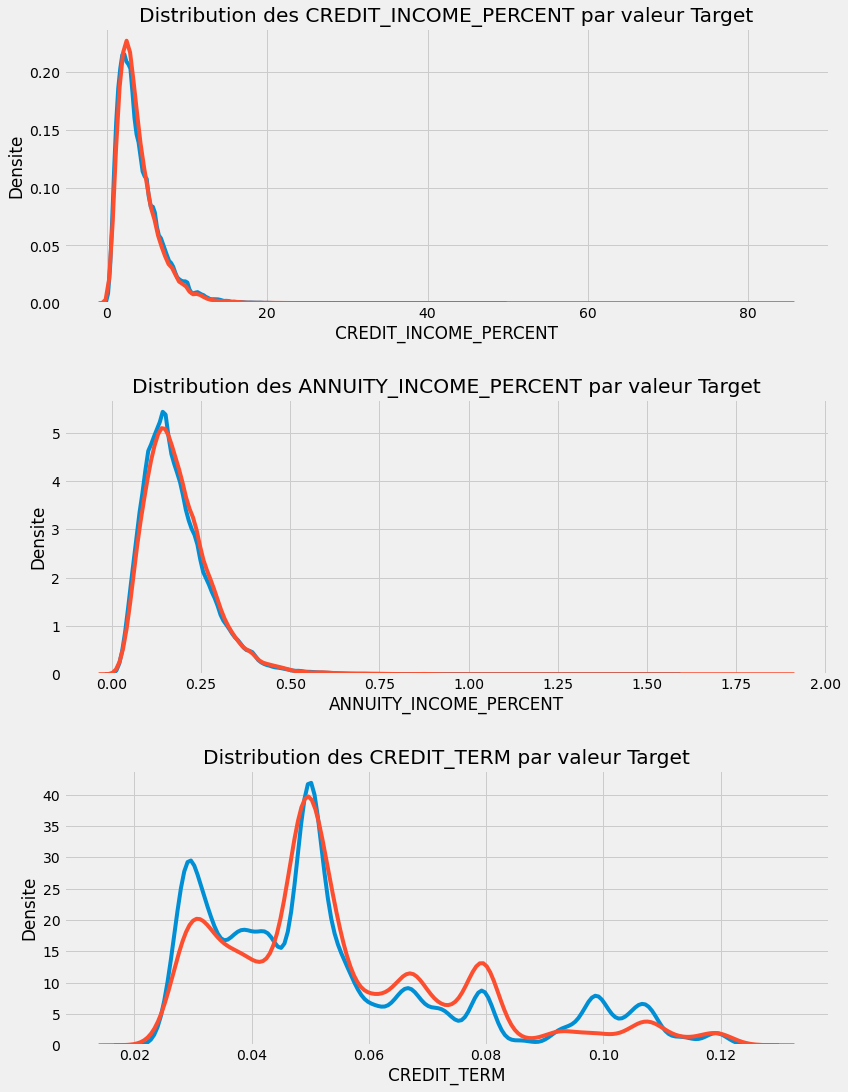

In [34]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot remboursement prest
    sns.kdeplot(application_train_domain.loc[application_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot prets non rembourses
    sns.kdeplot(application_train_domain.loc[application_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution des %s par valeur Target' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Densite');
    
plt.tight_layout(h_pad = 2.5)

Il est difficile de dire à l'avance si ces nouvelles fonctionnalités seront utiles. La seule façon de le dire avec certitude, c'est de les essayer !

# <a id='C5'>5. Modelisation</a>

## <a id='C5.1'>5.1. Modelisation avec PYCARET(SMOTE)</a>

Commencons nos premiers tests de modelisation avec **pycaret** qui offre une modelisation avec SMOTE.
Cette premiere modelisation va nous permettre de selectionner les modeles qui **maximisent le Recall**. Ensuite nous ferons une modelisation plus performante afin de choisir enfin le modele qui convient le mieux a notre imbalanced classification et qui soit le plus performant.

Ensuite :
- Choix du meilleur modele avec Fbeta Score : une metrique plus adapte avec un parametre de poids Beta qui permet de balancer le recall et la precision comme on le souhaite
- une fois le bon modele choisi nous effectueront un **threshold moving** optimal afin de diminuer encore plus les faux negatifs.
- et enfin une analyse d'interpretaion des resultats avec **SHAP**

## Setting up Environment in PyCaret - Preprocessing

In [34]:
from pycaret.classification import *

In [35]:
exp_credit = setup(data = application_train_domain, target = 'TARGET', session_id=123,
                   normalize = True,
                   transformation = True,
                   ignore_low_variance = True,
                   remove_outliers = True,
                   remove_multicollinearity = True,
                   multicollinearity_threshold = 0.95,
                   fix_imbalance = True #SMOTE
                  )

## Comparing Models

### Pipelines - Comparaison des modeles (Cross validation)

In [36]:
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
lightgbm  Light Gradient Boosting Machine   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

In [37]:
estimators = ['nb', 'dt', 'gpc', 'ada', 'gbc', 'lr', 'ridge', 'rf', 'lightgbm']

In [38]:
models().loc[estimators]

Name  \
ID                                          
nb                            Naive Bayes   
dt               Decision Tree Classifier   
gpc           Gaussian Process Classifier   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lr                    Logistic Regression   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
lightgbm  Light Gradient Boosting Machine   

                                                  Reference  Turbo  
ID                                                                  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True

In [39]:
top3 = compare_models(include = estimators)

## Commentaires sur les resultats :

Nous voyons que : 
- les modeles ensemblistes rf, lightgbm, gbc et ada  ont un Accuracy trop eleve, ce qui rappelle l'**accuracy paradox** de plus leurs Recall est pratiquement nul ce qui signifie que les faux negatifs sont tres eleves ce qui est contraire au resultat qu'on cherche.
- Par contre LogisticRegression, Ridge et Naive Bayes ont des recall eleve ce qui nous incite a les choisir pour la suite.
- Remarque : Ridge n'offre pas la possibilite de faire un threshold moving car il n'a pas de predict_proba. Les classes sont predites en 0 ou a directement.


## <a id='C5.2'>5.2. Modelisation - RandomSearchCV - pipeline avec SMOTE</a>

<b> Comprendre SMOTE: </b>
<ul>
<li> <b> Resoudre le probleme de desequilibre des classes: </b> SMOTE cree des synthetic points a partir de la classe minoritaitre pour faire un equilibre entre la classe minoritaire et majoritaire. </li>
<li><b>Endroit des synthetic points: </b>   SMOTE sélectionne la distance entre les voisins les plus proches de la classe minoritaire, entre ces distances, il crée des syntetic points. </li>
<li> <b>But final:  </b> Plus d'informations sont conservées car nous n'avons pas eu à supprimer de lignes contrairement au undersimpling<li><b> Accuracy || Time Tradeoff: </b> Bien qu'il soit probable que SMOTE soit plus précis que le undersimpling aléatoire, l'entraînement prendra plus de temps car aucune ligne n'est éliminée..</li>

</ul>

### Erreur de Overfitting et de DATA Leakage lors de la Cross Validation:
## Overfitting durant la Cross Validation:  
Si vous voulez faire un undersimpling ou un oversimpling de vos données, vous ne devez pas le faire avant la cross validation. Pourquoi, parce que vous influencerez directement l'ensemble de la validation avant de mettre en œuvre la cross validation provoquant un problème de "fuite de données".

### La MAUVAİSE Methode:
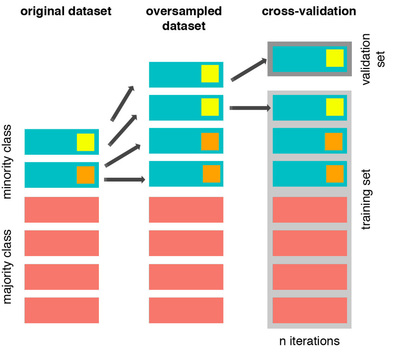
<br>
Si nous obtenons la classe minoritaire ("defaut de remboursement) dans notre cas, et créons les syntetic points avant la cross validation, nous avons une certaine influence sur "l'ensemble de validation" du processus de cross validation. Rappelez-vous comment fonctionne la cross validation, supposons que nous divisons les données en 5 lots, 4/5 de l'ensemble de données sera l'ensemble d'apprentissage tandis que 1/5 sera l'ensemble de validation. Le test set ne doit pas être touché ! Pour cette raison, nous devons faire la création de points de données synthétiques "pendant" la cross validation et pas avant, comme ci-dessous : <br>


### La Bonne Methode:

Comme vous le voyez ci-dessus, SMOTE se produit "pendant" la cross validation et non "avant" le processus de cross validation. Les données synthétiques sont créées uniquement pour le train set sans affecter l'ensemble de validation.



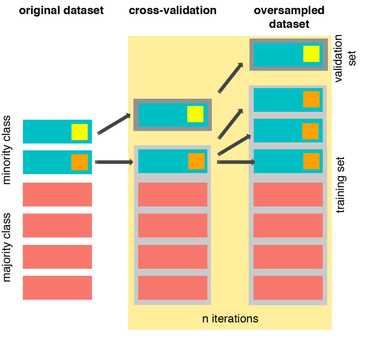

**References**: 
<ul>
<li><a src="https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation"> 
DEALING WITH IMBALANCED DATA: UNDERSAMPLING, OVERSAMPLING AND PROPER CROSS-VALIDATION </a></li> 

<li> <a src="http://rikunert.com/SMOTE_explained "> SMOTE explained for noobs  </a></li>
<li> <a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s"> Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a></li>
</ul>

### <a id='C5.2.1'>5.2.1. Pre-processing</a>

## Encodage des Variables Categorielles

Avant d'aller plus loin, nous devons nous occuper des variables catégorielles embêtantes. Un modèle d'apprentissage automatique ne peut malheureusement pas gérer les variables catégorielles (à l'exception de certains modèles tels que LightGBM. 

Par conséquent, nous devons encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle.

## Train

In [60]:
application_train_domain.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_EMPLOYED_ANOM',
       'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM',
       'DAYS_EMPLOYED_PERCENT'],
      dtype='object', length=127)

In [61]:
application_train_domain.columns[2:]

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_EMPLOYED_ANOM',
       'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM',
       'DAYS_EMPLOYED_PERCENT'],
      dtype='object', length=125)

In [62]:
cols = application_train_domain.columns[2:]
cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_EMPLOYED_ANOM',
       'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM',
       'DAYS_EMPLOYED_PERCENT'],
      dtype='object', length=125)

In [63]:
df1 = application_train_domain['SK_ID_CURR']
df2 = application_train_domain[cols]

df3 = pd.concat([df1, df2], axis=1)
# one-hot encoding des variables categorielles
y_train = application_train_domain['TARGET']

X_train = pd.get_dummies(df3)

## Test

In [64]:
X_test = pd.get_dummies(application_test_domain)

### Aligning Training and Testing Data

Il doit y avoir les mêmes caractéristiques (colonnes) dans les données de training et de test. Le one-hot encodage a créé plus de colonnes dans les données d'apprentissage car il y avait des variables catégorielles avec des catégories non représentées dans les données de test. Pour supprimer les colonnes des données d'apprentissage qui ne figurent pas dans les données de test, nous devons "aligner" les dataframes. Nous extrayons d'abord la colonne cible des données d'apprentissage (car cela ne figure pas dans les données de test, mais nous devons conserver ces informations). Lorsque nous effectuons l'alignement, nous devons nous assurer de définir `axis = 1` pour aligner les dataframes en fonction des colonnes et non des lignes !

In [65]:
# Align the training and testing data, keep only columns present in both dataframes
X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)

print('Training Features shape: ', X_train.shape)
print('Testing Features shape: ', X_test.shape)

Training Features shape:  (307511, 246)
Testing Features shape:  (48744, 246)


In [66]:
feature_names = X_train.columns

<font color='red'> Rappelons que les donnees de test ne seront utilises que dans la partie interpretation avec SHAP</font>

## Imputation des valeurs manquantes - Transformation StandardScaler 

In [67]:
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#Median imputation of missing values 
imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')

# Fit on the training data
imputer.fit(X_train)

# impute training data
X_train = imputer.transform(X_train)

# normalize the data
X_train = StandardScaler().fit_transform(X_train)

In [68]:
# Fit on the test data
imputer.fit(X_test)

# impute test data
X_test = imputer.transform(X_test)

# normalize the data
X_test = StandardScaler().fit_transform(X_test)

### <a id='C5.2.2'>5.2.2. Modelisation avec SMOTE - imbalanced make pipeline</a>

In [69]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB

import collections
from collections import Counter

# model pipeline cross validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold

# imbalanced learn
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

# metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix

# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax

# Other
import warnings
warnings.filterwarnings("ignore")
import pickle

#plot
from matplotlib import pyplot

## Fbeta-measure : Une metrique convenable pour les imbalanced class problem : 

**Fbeta-measure** est une métrique à score unique configurable pour évaluer un modèle de classification binaire basé sur les prédictions faites pour la classe positive.

La mesure Fbeta est calculée en utilisant les mesures **Precision** et **Recall**.

- La **Precision** est une métrique qui calcule le pourcentage de prédictions correctes pour la classe positive. 
- Le **Recall** calcule le pourcentage de prédictions correctes pour la classe positive sur toutes les prédictions positives qui pourraient être faites. 

<font color='red'> La maximisation de la **Precision** minimisera les erreurs de faux positifs, tandis que la maximisation du **Recall** minimisera les erreurs de faux négatifs</font>.

La **mesure F1** est calculée comme la moyenne harmonique de la Precision et du Recall, en donnant à chacun la même pondération. Il permet d'évaluer un modèle en tenant compte à la fois de la Precision et du Rappel à l'aide d'un score unique, ce qui est utile pour décrire les performances du modèle et pour comparer les modèles.

La **Fbeta-measure** est une généralisation de la **F-measure** qui ajoute un paramètre de configuration appelé **beta**. 
- Une valeur bêta par défaut est 1, ce qui est identique à la mesure F. 
- **Une valeur bêta plus petite, telle que 0.5, donne plus de poids à la Precision et moins au Recall**
- tandis qu'une valeur bêta plus grande, telle que 2, donne moins de poids à la Precision et plus de poids au Recall dans le calcul du score.

C'est une métrique utile à utiliser lorsque la Precision et le Recall sont importants mais qu'un peu plus d'attention est nécessaire sur l'un ou l'autre, par exemple lorsque les faux négatifs plus importants que les faux positifs, ou l'inverse.

**Rappel** : 
- negative (class 0) : donc dans note cas les prets rembourses TARGET == 0
- positive (class 1) : les prets non rembourses TARGET == 1 

<font color='red'>Dans notre cas les faux negatifs doivent etre minimises mais pas trop afin de ne pas perdre de clients</font>
donc il faut minimiser les faux negatifs par maximisation du recall.

Nous choisirons une valeur beta egale a 3 pour commencer. Cette valeur donnera plus de poids au recall et moins a la Precision.


In [58]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))

Length of X (train): 307511 | Length of y (train): 307511


In [46]:
# Implementation de la Technique SMOTE
# Cross Validaer avec la bonne methode
def test_SMOTE_model(model, param_distr, X_train , y_train, n_iter, n_splits, Beta):
    # List to append the score and then find the average
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    fbeta_lst = []

    rand_CV = RandomizedSearchCV(model, param_distr, n_iter=n_iter)    

    StratKF = StratifiedKFold(n_splits=n_splits)

    for train, test in StratKF.split(X_train, y_train):
        # SMOTE realisee durant la Cross Validation non avant..
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_CV)
        model = pipeline.fit(X_train[train], y_train[train])
        best_estim = rand_CV.best_estimator_
        y_pred = best_estim.predict(X_train[test])
        # Scores
        accuracy_lst.append(pipeline.score(X_train[test], y_train[test]))
        auc_lst.append(roc_auc_score(y_train[test], y_pred))
        precision_lst.append(precision_score(y_train[test], y_pred))
        recall_lst.append(recall_score(y_train[test], y_pred))
        f1_lst.append(f1_score(y_train[test], y_pred))        
        fbeta_lst.append(fbeta_score(y_train[test], y_pred,beta=Beta))
        
    avg_accuracy = np.mean(accuracy_lst)
    avg_auc = np.mean(auc_lst)
    avg_precision = np.mean(precision_lst)
    avg_recall = np.mean(recall_lst)
    avg_f1 = np.mean(f1_lst)    
    avg_fbeta = np.mean(fbeta_lst)
    
    return avg_accuracy, avg_auc, avg_precision, avg_recall, avg_f1, avg_fbeta, best_estim



### <a id='C5.2.3'>5.2.3. Performance des differents classifieurs</a>

In [85]:
performance_df = pd.DataFrame(columns = ['Model', 'Accuracy_Score', 'AUC_Score', 'Precision_Score', 'Recall_Score',
                                         'F1_Score', 'Fbeta_Score'])

## LogisticRegression

In [47]:
model = LogisticRegression()

#param_distr = {"penalty": ['l1','l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1], 'random_state' : range(10000)}
param_distr = {'C': [0.0001],
               'class_weight': [None],
               'dual': [False],
               'fit_intercept': [True],
               'intercept_scaling': [1],
               'l1_ratio': [None],
               'max_iter': [100],
               'multi_class': ['auto'],
               'n_jobs': [None],
               'penalty': ['l2'],
               'random_state': [7994],
               'solver': ['lbfgs'],
               'tol': [0.0001],
               'verbose': [0],
               'warm_start': [False]}

n_iter = 4
n_splits = 5 # number of folds
Beta = 3

avg_accuracy, avg_auc, avg_precision, avg_recall, avg_f1, avg_fbeta, lr_model = test_SMOTE_model(model, 
                                                                                       param_distr, 
                                                                                       X_train, 
                                                                                       y_train, 
                                                                                       n_iter,
                                                                                       n_splits,
                                                                                       Beta)

In [87]:
performance_df = performance_df.append({'Model' : 'LogisticRegression', 
                                        'Accuracy_Score' : avg_accuracy, 
                                        'AUC_Score' : avg_auc, 
                                        'Precision_Score' : avg_precision, 
                                        'Recall_Score' : avg_recall,
                                        'F1_Score' : avg_f1, 
                                        'Fbeta_Score' : avg_fbeta},
                                        ignore_index=True
                                      )

In [88]:
performance_df = performance_df.sort_values(by=['Fbeta_Score', 'Precision_Score', 'Recall_Score'],ascending=False)
performance_df

Model  Accuracy_Score  AUC_Score  Precision_Score  \
0  LogisticRegression        0.698359   0.674737         0.160473   

   Recall_Score  F1_Score  Fbeta_Score  
0      0.646566  0.257117     0.496217

## RidgeClassifier

In [89]:
model = RidgeClassifier()

param_distr = {'alpha': [1.0, 2.0, 3.0, 4.0],
              'tol' : [0.1, 0.01, 0.001, 0.0001]}

n_iter = 4
n_splits = 5 # number of folds
Beta = 3

avg_accuracy, avg_auc, avg_precision, avg_recall, avg_f1, avg_fbeta, ridge_model = test_SMOTE_model(model, 
                                                                                       param_distr, 
                                                                                       X_train, 
                                                                                       y_train, 
                                                                                       n_iter,
                                                                                       n_splits,
                                                                                       Beta)

In [90]:
performance_df = performance_df.append({'Model' : 'RidgeClassifier', 
                                        'Accuracy_Score' : avg_accuracy, 
                                        'AUC_Score' : avg_auc, 
                                        'Precision_Score' : avg_precision, 
                                        'Recall_Score' : avg_recall,
                                        'F1_Score' : avg_f1, 
                                        'Fbeta_Score' : avg_fbeta},
                                        ignore_index=True
                                      )

In [91]:
performance_df = performance_df.sort_values(by=['Fbeta_Score', 'Precision_Score', 'Recall_Score'],ascending=False)
performance_df

Model  Accuracy_Score  AUC_Score  Precision_Score  \
1     RidgeClassifier        0.696047   0.676639         0.160496   
0  LogisticRegression        0.698359   0.674737         0.160473   

   Recall_Score  F1_Score  Fbeta_Score  
1      0.653494  0.257693     0.499906  
0      0.646566  0.257117     0.496217

## GaussianNB

In [92]:
model = GaussianNB()


param_distr = {'var_smoothing': np.logspace(0,-9, num=100)}

n_iter = 4
n_splits = 5 # number of flods
Beta = 3

avg_accuracy, avg_auc, avg_precision, avg_recall, avg_f1, avg_fbeta, nb_model = test_SMOTE_model(model, 
                                                                                       param_distr, 
                                                                                       X_train, 
                                                                                       y_train, 
                                                                                       n_iter,
                                                                                       n_splits,
                                                                                       Beta)

In [93]:
performance_df = performance_df.append({'Model' : 'GaussianNB', 
                                        'Accuracy_Score' : avg_accuracy, 
                                        'AUC_Score' : avg_auc, 
                                        'Precision_Score' : avg_precision, 
                                        'Recall_Score' : avg_recall,
                                        'F1_Score' : avg_f1, 
                                        'Fbeta_Score' : avg_fbeta},
                                        ignore_index=True
                                      )

In [94]:
performance_df = performance_df.sort_values(by=['Fbeta_Score', 'Precision_Score', 'Recall_Score'],ascending=False)
performance_df

Model  Accuracy_Score  AUC_Score  Precision_Score  \
0     RidgeClassifier        0.696047   0.676639         0.160496   
1  LogisticRegression        0.698359   0.674737         0.160473   
2          GaussianNB        0.300266   0.545956         0.089844   

   Recall_Score  F1_Score  Fbeta_Score  
0      0.653494  0.257693     0.499906  
1      0.646566  0.257117     0.496217  
2      0.838953  0.162275     0.457231

### <a id='C5.2.4'>5.2.4. Matrices de confusions et choix du meilleur modele</a>

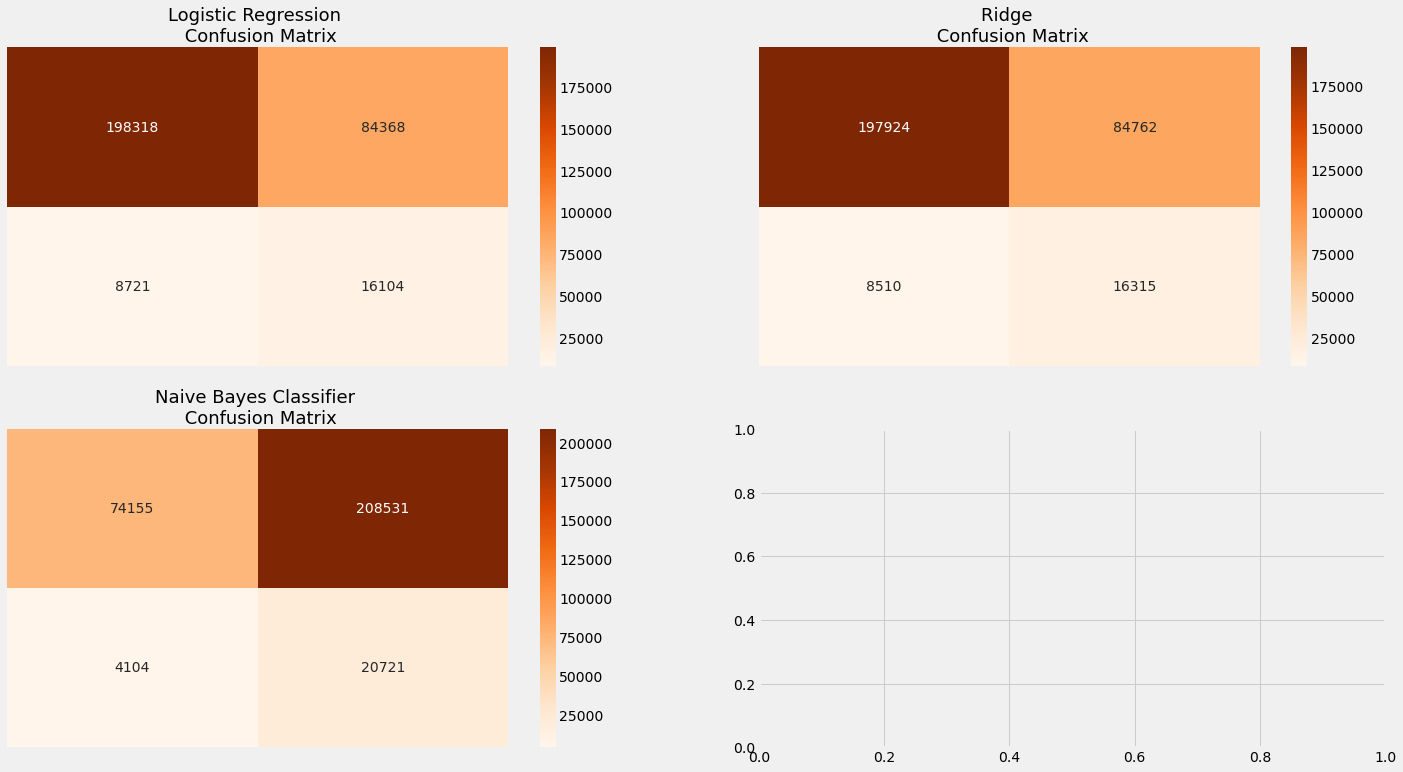

In [95]:
# Logistic Regression fitted using SMOTE technique
y_pred_lr = lr_model.predict(X_train)

# Ridge fitted using SMOTE technique
y_pred_ridge = ridge_model.predict(X_train)

# Naive Bayes fitted using SMOTE technique
y_pred_nb = nb_model.predict(X_train)

lr_cm = confusion_matrix(y_train, y_pred_lr)
ridge_cm = confusion_matrix(y_train, y_pred_ridge)
nb_cm = confusion_matrix(y_train, y_pred_nb)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(lr_cm, ax=ax[0][0], annot=True, fmt="d", cmap="Oranges")
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=18)
ax[0, 0].set_xticklabels(['', ''], fontsize=18, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=18, rotation=360)

sns.heatmap(ridge_cm, ax=ax[0][1], annot=True, fmt="d", cmap="Oranges")
ax[0][1].set_title("Ridge \n Confusion Matrix", fontsize=18)
ax[0][1].set_xticklabels(['', ''], fontsize=18, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=18, rotation=360)

sns.heatmap(nb_cm, ax=ax[1][0], annot=True, fmt="d", cmap="Oranges")
ax[1][0].set_title("Naive Bayes Classifier \n Confusion Matrix", fontsize=18)
ax[1][0].set_xticklabels(['', ''], fontsize=18, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=18, rotation=360)

plt.show()

## Choix du meilleur modele

Les faux negatifs sont de :
- 8 721 pour lr
- 8 510 pour ridge
- 4 104 pour Naive Bayes

Malgre ca l'etude suivante va montrer que le modele lr est mieux adapte pour notre cas, car ce qui compte aussi c'est de ne pas avoir trop de faux positifs avec une precision trop faible pour le modele Naive Bayes.

Nous preferons le modele lr sur le ridge car ce dernier n'offre pas la possibilite de faire un threshold moving, ces classes etant calcules directement (pas de predict_proba pour ce modele)

In [48]:
best_model = lr_model

In [104]:
display(lr_model.get_params(deep=True))

{'C': 0.0001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 7994,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## <a id='C5.3'>5.3. Threshold-Moving for Imbalanced Classification</a>

## Optimal Threshold for Precision-Recall Curve

In [49]:
# appliquons le threshold sur les probabilites pour creer les labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
 
# predire les probabilites 2 colonnes la premiere pour les 0 la deuxieme pour les 1
y_pred_probas = best_model.predict_proba(X_train)
# gardons une des probabilites (pour les positifs seulement) de toute facon leur somme est egale a 1
probs = y_pred_probas[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluer chaque threshold
precision = [precision_score(y_train, to_labels(probs, t)) for t in thresholds]
recall = [recall_score(y_train, to_labels(probs, t)) for t in thresholds]
fbeta = [fbeta_score(y_train, to_labels(probs, t),beta=Beta) for t in thresholds]
# get best threshold
ix = argmax(fbeta)

ix : 358  Optimal Threshold : 0.358  Fbeta-Score : 0.5273122970935826
recall : 0.8256998992950655  precision : 0.12400408950944035


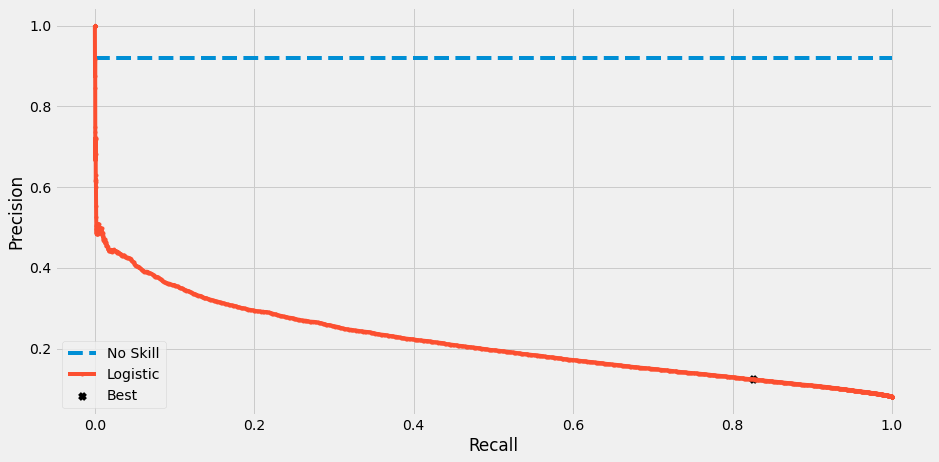

In [50]:
# optimal threshold for precision-recall curve

# plot the roc curve for the model
no_skill = len(y_train[y_train==0]) / len(y_train)

plt.figure(figsize=(14,7))

pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')

print('ix :',ix,' Optimal Threshold :',thresholds[ix],' Fbeta-Score :',fbeta[ix])
print('recall :',recall[ix],' precision :',precision[ix])

pyplot.scatter(recall[ix], precision[ix], marker='x', color='black', label='Best')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()

# show the plot
pyplot.show()

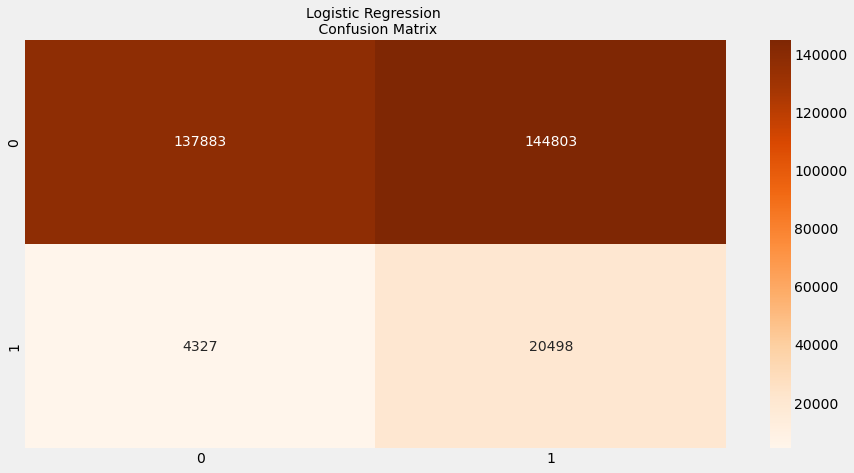

In [52]:
# Logistic Regression fitted using SMOTE technique
# calcul des labels predits avec le threshold optimal
optim_threshold = thresholds[ix]
y_pred_lr = (probs >= optim_threshold).astype('int')

lr_cm = confusion_matrix(y_train, y_pred_lr)

plt.figure(figsize=(14,7))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Logistic Regression \n Confusion Matrix", fontsize=14)

plt.show()

**Les faux negatifs sont passes de 8 721 a 4 327 avec threshold optimal**

# Export The best model and the optim_threshold

In [53]:
model_file = "../Projet7/Data/best_model_optim_threshold.pkl"
with open(model_file,mode='wb') as model_f:
    pickle.dump((best_model,optim_threshold), model_f)

# <a id='C6'>6. Interpretation : SHAP (SHapley Additive exPlanations)</a>

## load best_model

In [70]:
model_file = "../Projet7/Data/best_model_optim_threshold.pkl"
with open(model_file,mode='rb') as model_f:
    best_model, optim_threshold = pickle.load(model_f)

In [71]:
display(optim_threshold)
display(best_model.get_params(deep=True))

0.358

{'C': 0.0001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 7994,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Explain Predictions using SHAP Values

### Create Explainer Object (LinearExplainer)

In [72]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

We will use SHAP KernelExplainer to explain the LogisticRegression

## What Does the KernelExplainer Do?

The KernelExplainer builds a weighted linear regression by using your data, your predictions, and whatever function that predicts the predicted values. It computes the variable importance values based on the Shapley values from game theory, and the coefficients from a local linear regression.

## Arguments of KernelExplainer() function:

- model: The model to be explained. The output of the model can be a vector of size n_samples or a matrix of size [n_samples x n_output] (for a classification model).
- data: Background dataset to generate the perturbed dataset required for training surrogate models. We simulate “missing” (‘0’s in zᵢ) by replacing the feature with the values it takes in the background dataset. So if the background dataset is a simple sample of all zeros, then we would approximate a feature being missing by setting it to zero. For small problems this background dataset can be the whole training set, but for larger problems consider using a single reference value or using the kmeans function to summarize the dataset.
- link: A function to connect feature contribution values to the model output. For a classification model, we generally explain the logit of the predicted probability as a sum of feature contributions. Hence, if the output of the “model” (the first argument) is a probability, we set link = “logit” to get the feature contributions in logit form.

In [73]:
data_backgr = shap.sample(X_train, 100)

In [74]:
explainer = shap.KernelExplainer(model=best_model.predict_proba, data=data_backgr,link='logit')

Using many background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.

## expected Value

In [75]:
expected_value = explainer.expected_value
expected_value

array([ 0.22473568, -0.22473568])

In [76]:
X_test_1000 = X_test[:1000]
df_X_test_1000 = pd.DataFrame(X_test_1000,columns=feature_names)

In [52]:
shap_values = explainer.shap_values(X_test_1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Interpreter une unique prediction - Force Plot

In [53]:
print(f'Prediction pour le premier sample dans X_test: {best_model.predict_proba(X_test_1000[0].reshape(1, -1))}')

Prediction pour le premier sample dans X_test: [[0.57313032 0.42686968]]


In [80]:
# plot the SHAP values for the 
shap.initjs()
shap.force_plot(expected_value[0], shap_values[0][0,:], X_test_1000[0].reshape(1, -1), link="logit",\
               feature_names=feature_names)

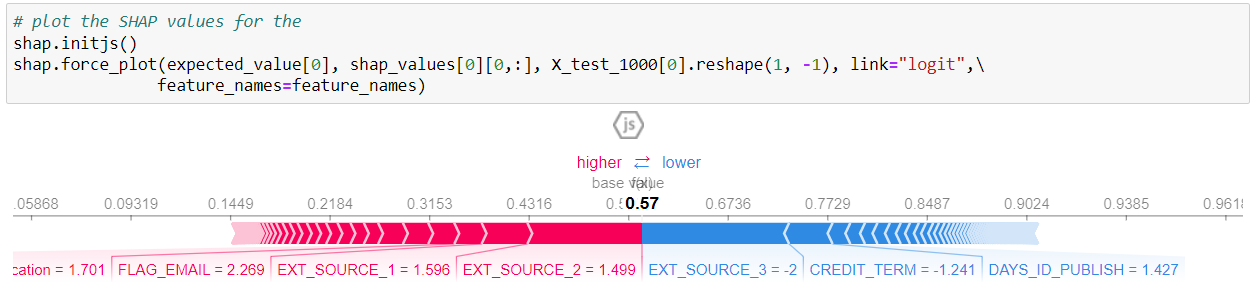

In [79]:
# plot the SHAP values for the 
shap.initjs()
shap.force_plot(expected_value[1], shap_values[1][0,:], X_test_1000[0].reshape(1, -1), link="logit",\
               feature_names=feature_names)

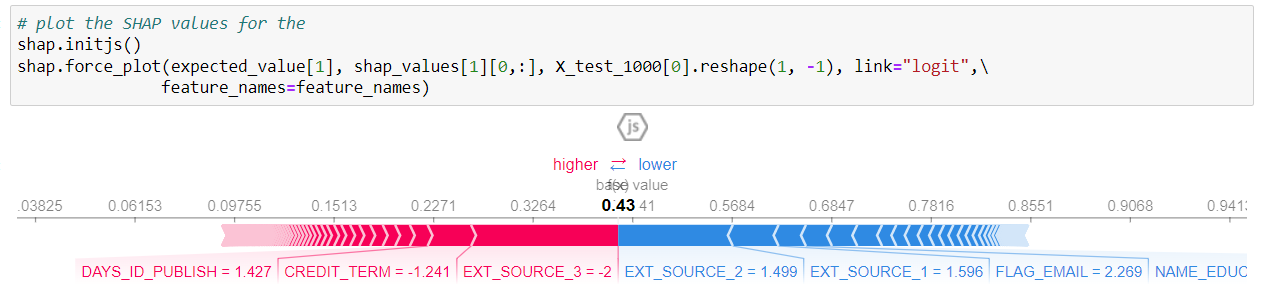

L'argument link="logit" convertit les valeurs logit en probabilité. 

Chaque tracé affiche la valeur de probabilité de base pour la classe respective sur l'ensemble de données d'apprentissage. 

- La couleur bleue indique que la caractéristique a diminué la probabilité et 
- la couleur rouge indique que la valeur de la caractéristique a augmenté la probabilité.

## Interpreter plusieurs predictions

Si nous prenons le graphique ci-dessus pour une classe quelconque pour chaque échantillon, les faisons pivoter de 90 degrés et les empilons côte à côte, nous pouvons expliquer les prédictions pour plusieurs échantillons dans un seul graphique (notez que les échantillons sont classés par similarité):

In [61]:
X_test_1000[:30]

array([[-1.72335253, -0.5599885 , -0.42780873, ..., -0.12868145,
         0.92841285, -0.0857741 ],
       [-1.72331376, -0.5599885 , -0.78241325, ..., -0.12868145,
        -1.07710702, -0.0857741 ],
       [-1.72323621, -0.5599885 ,  0.23707473, ..., -0.12868145,
        -1.07710702, -0.0857741 ],
       ...,
       [-1.72154965, -0.5599885 ,  0.45870255, ..., -0.12868145,
         0.92841285, -0.0857741 ],
       [-1.72130733, -0.5599885 , -0.87106438, ..., -0.12868145,
        -1.07710702, -0.0857741 ],
       [-1.7212104 , -0.5599885 ,  1.78846948, ..., -0.12868145,
        -1.07710702, -0.0857741 ]])

In [78]:
## Prets rembourses output
shap.initjs()
shap.force_plot(expected_value[0], shap_values[0][:30,:], X_test_1000[:30], link="logit",\
               feature_names=feature_names)

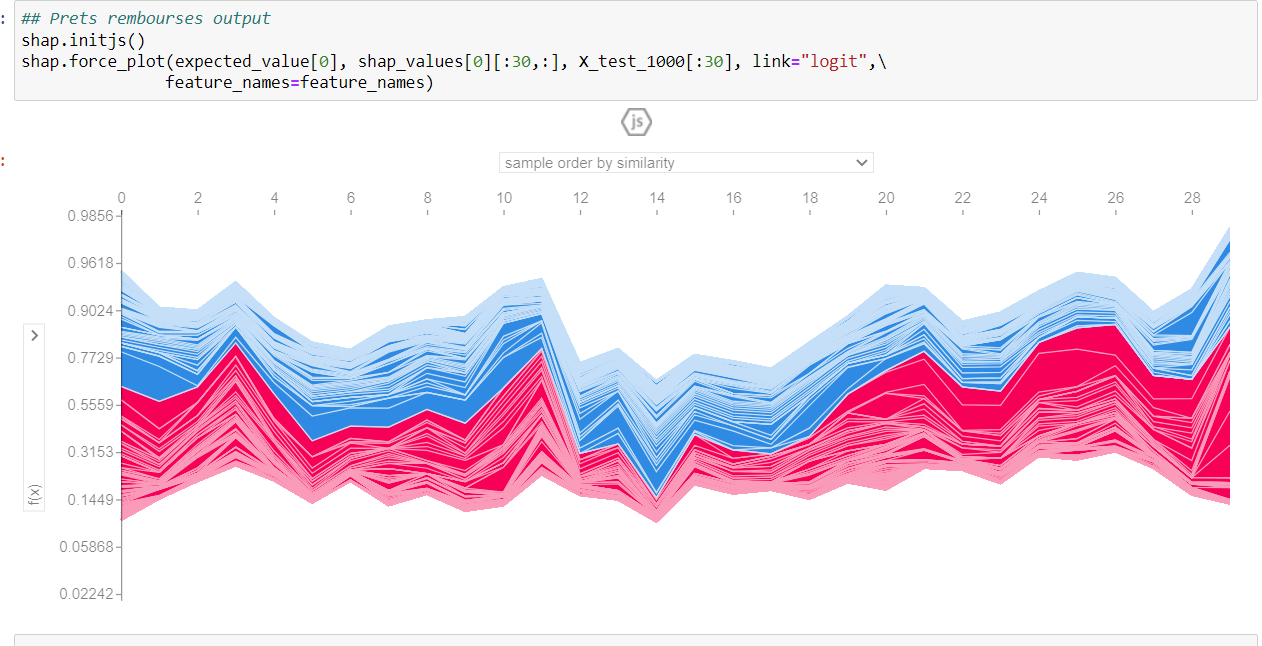

In [81]:
## Prets non rembourses output
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:30,:], X_test_1000[:30], link="logit",\
               feature_names=feature_names)

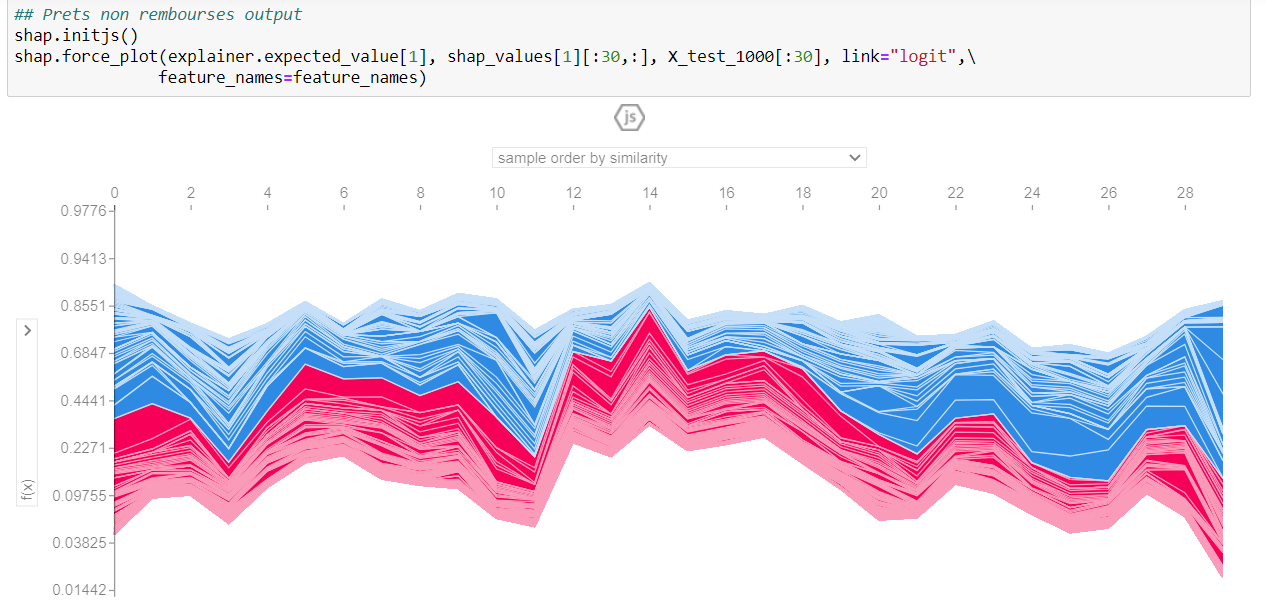

## SHAP Summary Plots

shap.summary_plot() peut tracer les valeurs moyennes de shap pour chaque classe si elle est fournie avec une liste de valeurs de shap (la sortie de explainer.shap_values() pour un problème de classification) comme ci-dessous :

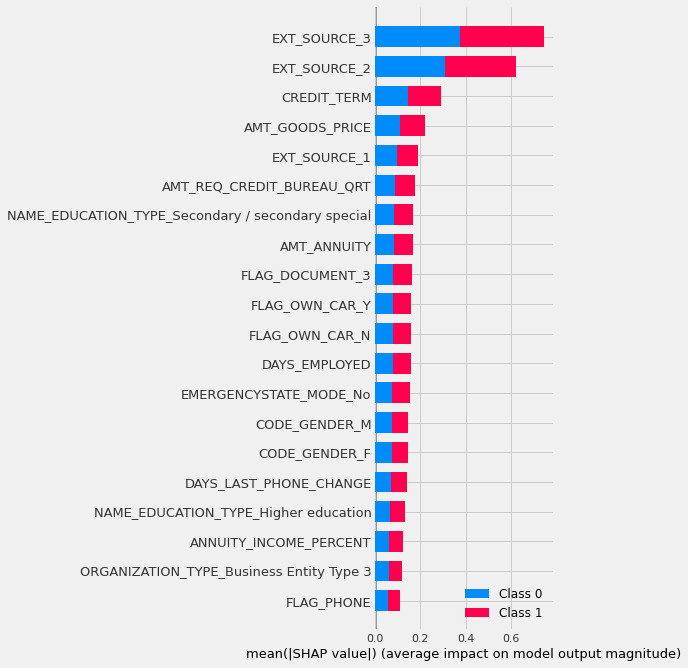

In [82]:
shap.summary_plot(shap_values, X_test_1000, feature_names=feature_names)

Le graphique ci-dessus indique que EXT_SOURCE_3 (rappelons que ce feature est legerement correlle a l'age du client)

a eu la plus grande influence sur les prédictions pour les 2 classes suivi de EXT_SOURCE_2 , CREDIT_TERM et AMT_GOODS_PRICE.

S'il est fourni avec un seul ensemble de valeurs SHAP, shap.summary_plot() crée un nuage de points de densité des valeurs SHAP pour chaque entité afin d'identifier l'impact que chaque caractéristique a sur la sortie du modèle.

Les caractéristiques sont triées par la somme des amplitudes des valeurs SHAP sur tous les échantillons.

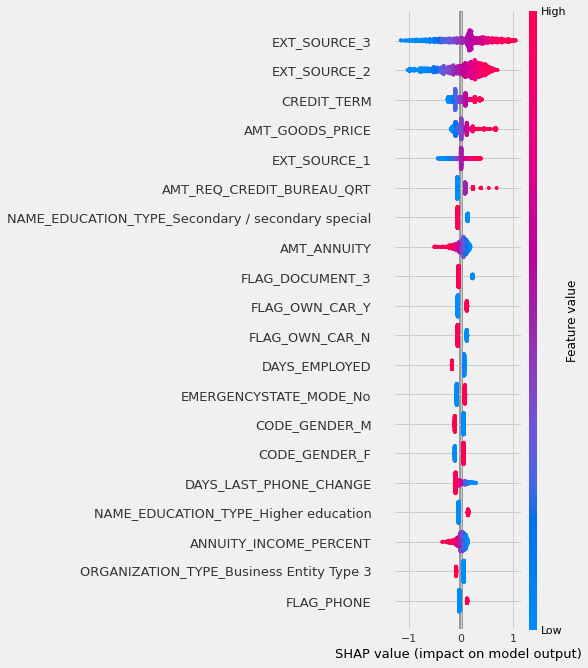

In [83]:
## Prets rembourses output
shap.summary_plot(shap_values[0], X_test_1000, feature_names=feature_names)

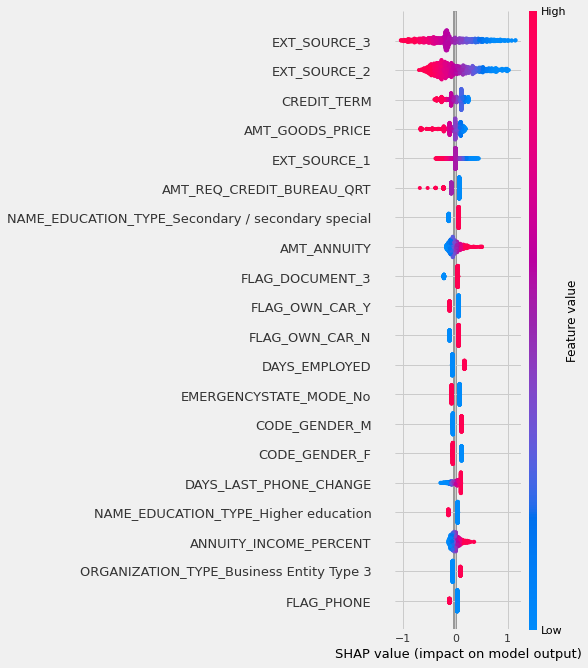

In [84]:
## Prets non rembourses output
shap.summary_plot(shap_values[1], X_test_1000, feature_names=feature_names)

On voit que ce sont les memes features qui ont un fort impact dans la prediction du rembousement ou non 

In [85]:
application_train_domain[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'CREDIT_TERM', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1']]

EXT_SOURCE_3  EXT_SOURCE_2  CREDIT_TERM  AMT_GOODS_PRICE  EXT_SOURCE_1
0           0.139376      0.262949     0.060749         351000.0      0.083037
1                NaN      0.622246     0.027598        1129500.0      0.311267
2           0.729567      0.555912     0.050000         135000.0           NaN
3                NaN      0.650442     0.094941         297000.0           NaN
4                NaN      0.322738     0.042623         513000.0           NaN
...              ...           ...          ...              ...           ...
307506           NaN      0.681632     0.108198         225000.0      0.145570
307507           NaN      0.115992     0.044524         225000.0           NaN
307508      0.218859      0.535722     0.044239         585000.0      0.744026
307509      0.661024      0.514163     0.054592         319500.0           NaN
307510      0.113922      0.708569     0.072767         675000.0      0.734460

[307511 rows x 5 columns]

## Decision_Plot

When is a decision plot helpful?
There are several use cases for a decision plot. We present several cases here. 
1. Show a large number of feature effects clearly. 
2. Visualize multioutput predictions. 
3. Display the cumulative effect of interactions. 
4. Explore feature effects for a range of feature values. 
5. Identify outliers. 
6. Identify typical prediction paths. 
7. Compare and contrast predictions for several models.

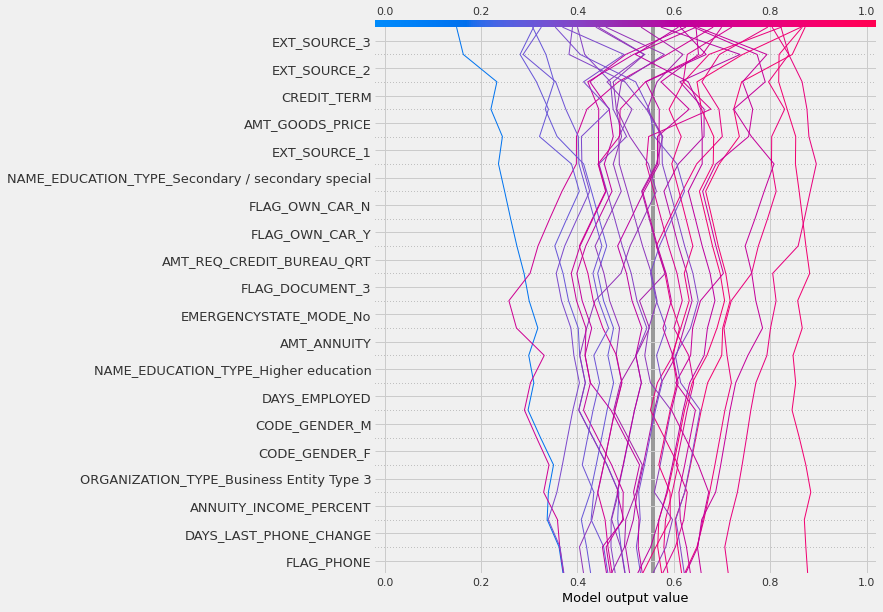

In [74]:
shap.decision_plot(expected_value[0], shap_values[0][:30,:], feature_names, link='logit')

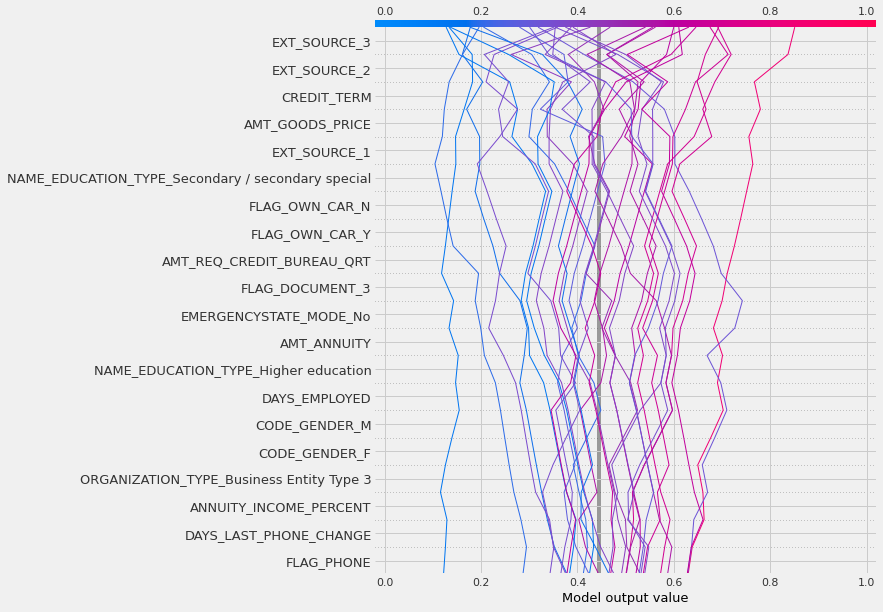

In [75]:
shap.decision_plot(expected_value[1], shap_values[1][:30,:], feature_names, link='logit')

## decision plot pour le premier sample

In [77]:
feature_names

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=246)

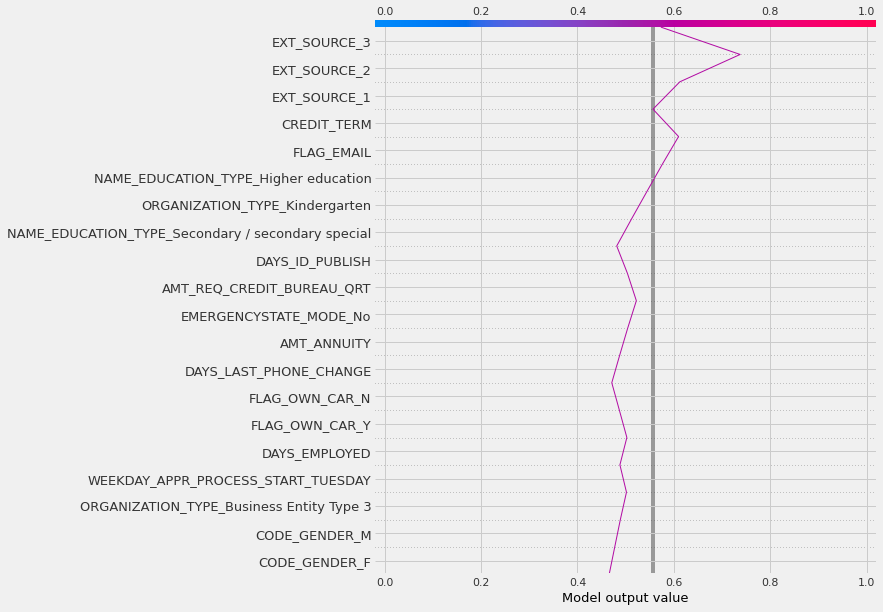

In [78]:
row_index = 0
shap.decision_plot(expected_value[0], shap_values[0][row_index,:], feature_names=list(feature_names), link='logit')

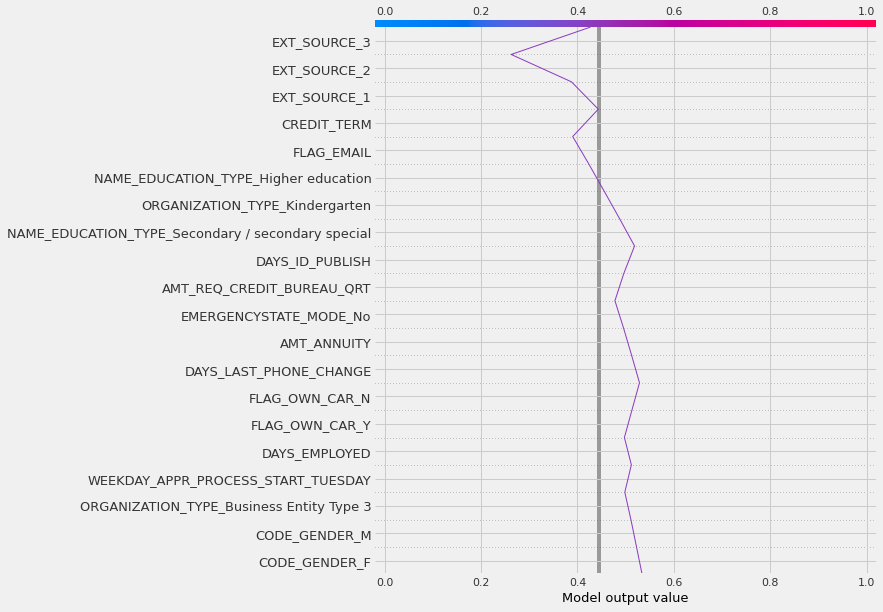

In [79]:
row_index = 0
shap.decision_plot(expected_value[1], shap_values[1][row_index,:], feature_names=list(feature_names), link='logit')

### Dependence Plot

'EXT_SOURCE_3', 'EXT_SOURCE_2', 'CREDIT_TERM', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1'

## DAYS_BIRTH

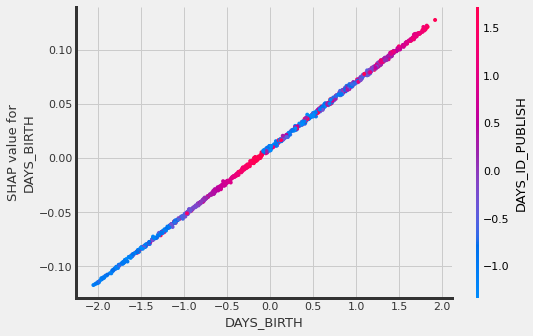

In [75]:
shap.dependence_plot("DAYS_BIRTH",
                     shap_values[0],
                     features=df_X_test_1000,
                     feature_names=feature_names,
                     )

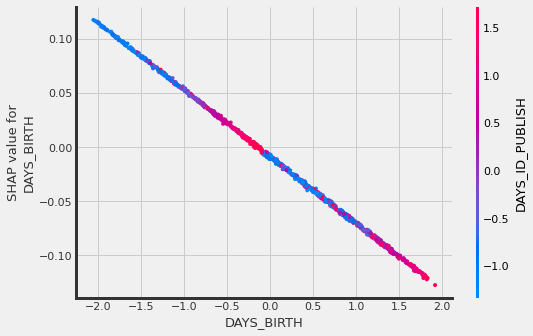

In [76]:
shap.dependence_plot("DAYS_BIRTH",
                     shap_values[1],
                     features=df_X_test_1000,
                     feature_names=feature_names,
                     )

## CREDIT_TERM

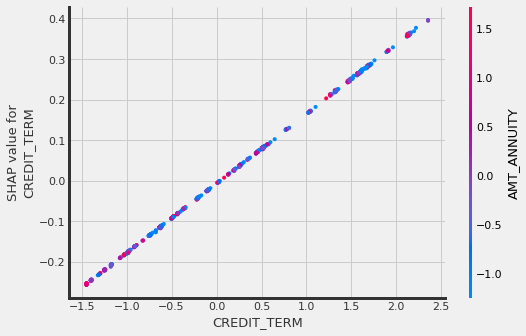

In [77]:
shap.dependence_plot("CREDIT_TERM",
                     shap_values[0],
                     features=df_X_test_1000,
                     feature_names=feature_names,
                     )

## AMT_GOODS_PRICE

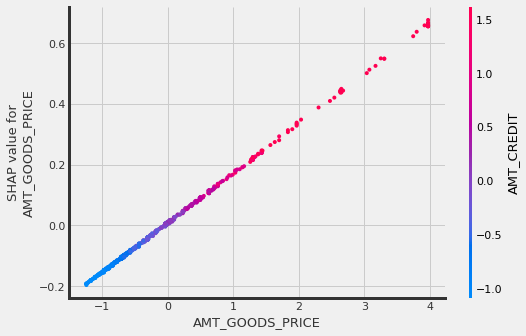

In [78]:
shap.dependence_plot("AMT_GOODS_PRICE",
                     shap_values[0],
                     features=df_X_test_1000,
                     feature_names=feature_names,
                     )

# Export des donnees pour le dashboard

# Client Info 

In [49]:
df_lisible = application_test_domain[["SK_ID_CURR","CODE_GENDER", "DAYS_BIRTH", "DAYS_EMPLOYED"]]

In [50]:
# Création de variables info clients : âge en années, durée emploi en années, genre : M ou F
df_lisible["GENDER"] = df_lisible["CODE_GENDER"].replace({'M' : "Male", 'F' : "Female"})
df_lisible['YEARS_BIRTH'] = -df_lisible["DAYS_BIRTH"]/365
df_lisible['YEARS_EMPLOYED'] = -df_lisible["DAYS_EMPLOYED"]/365
df_lisible.drop([ "DAYS_EMPLOYED", "DAYS_BIRTH", "CODE_GENDER"], axis=1, inplace=True)

In [51]:
df_lisible

SK_ID_CURR  GENDER  YEARS_BIRTH  YEARS_EMPLOYED
0          100001  Female    52.715068        6.380822
1          100005    Male    49.490411       12.243836
2          100013    Male    54.898630       12.213699
3          100028  Female    38.290411        5.112329
4          100038    Male    35.726027        6.002740
...           ...     ...          ...             ...
48739      456221  Female    54.712329       14.161644
48740      456222  Female    30.646575        3.147945
48741      456223  Female    43.621918        8.320548
48742      456224    Male    38.268493        7.482192
48743      456250  Female    38.252055        1.734247

[48744 rows x 4 columns]

In [52]:
info_cols = ["SK_ID_CURR",
                 "YEARS_BIRTH", 
                 "YEARS_EMPLOYED",
                 "NAME_INCOME_TYPE",
                 "AMT_INCOME_TOTAL",
                 "NAME_CONTRACT_TYPE",
                 "NAME_FAMILY_STATUS",
                 "GENDER",
                 "NAME_EDUCATION_TYPE"]

In [54]:
df_Client_Info = pd.merge(left=df_lisible, right=application_test_domain, 
                         left_on='SK_ID_CURR', right_on='SK_ID_CURR')
df_Client_Info.head()

SK_ID_CURR  GENDER  YEARS_BIRTH  YEARS_EMPLOYED NAME_CONTRACT_TYPE  \
0      100001  Female    52.715068        6.380822         Cash loans   
1      100005    Male    49.490411       12.243836         Cash loans   
2      100013    Male    54.898630       12.213699         Cash loans   
3      100028  Female    38.290411        5.112329         Cash loans   
4      100038    Male    35.726027        6.002740         Cash loans   

  CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0           F            N               Y             0          135000.0   
1           M            N               Y             0           99000.0   
2           M            Y               Y             0          202500.0   
3           F            N               Y             2          315000.0   
4           M            Y               N             1          180000.0   

   ...  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0  ...                         0.0                        0.0   
1  ...                         0.0                        0.0   
2  ...                         0.0                        0.0   
3  ...                         0.0                        0.0   
4  ...                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         NaN                       NaN   

  AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR CREDIT_INCOME_PERCENT  \
0                       0.0                        0.0              4.213333   
1                       0.0                        3.0              2.250182   
2                       1.0                        4.0              3.275378   
3                       0.0                        3.0              5.000000   
4                       NaN                        NaN              3.475000   

  ANNUITY_INCOME_PERCENT  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  
0               0.152300     0.036147               0.121044  
1               0.175455     0.077973               0.247398  
2               0.344578     0.105202               0.222477  
3               0.155614     0.031123               0.133515  
4               0.178150     0.051266               0.168021  

[5 rows x 128 columns]

In [55]:
df_Client_Info = df_Client_Info[info_cols]

## Replace the anom values of 'YEARS_EMPLOYED' by the mean value

In [56]:
df = df_Client_Info[df_Client_Info['YEARS_EMPLOYED']>0]

In [57]:
v = df['YEARS_EMPLOYED'].mean()
v

6.785586139637836

In [60]:
for i in df_Client_Info.index:
    if df_Client_Info.loc[i, 'YEARS_EMPLOYED'] < 0:
        df_Client_Info.loc[i, 'YEARS_EMPLOYED'] = v

In [61]:
df_Client_Info[df_Client_Info['YEARS_EMPLOYED']<0]

Empty DataFrame
Columns: [SK_ID_CURR, YEARS_BIRTH, YEARS_EMPLOYED, NAME_INCOME_TYPE, AMT_INCOME_TOTAL, NAME_CONTRACT_TYPE, NAME_FAMILY_STATUS, GENDER, NAME_EDUCATION_TYPE]
Index: []

## kneighbors

In [179]:
from sklearn.neighbors import KNeighborsClassifier

def neighbors(k, test_data, test_prediction):
    '''
        Function to generate a the k neighbors of all samples of the test data
        
        Inputs:
            k number of neighbors
        
        Returns:
            test_neighbors : the array of indexes of the k neighbors of every sample in the test data
        '''

    knn = KNeighborsClassifier(k, n_jobs=-1)
        
    knn.fit(test_data,  test_prediction)

    test_neighbors = knn.kneighbors(test_data)

    return test_neighbors

In [180]:
test_prediction = []

In [181]:
for i in range(len(test_data)):
    val = best_model.predict_proba(X_test[:1000][i].reshape(1,-1))[0][1].astype('float64')
    test_prediction.append(val)
    
test_prediction = (test_prediction >= optim_threshold).astype('int')

print(test_prediction)

[1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0
 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1
 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1
 1 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0
 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1
 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1
 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0
 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0
 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1
 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1
 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0
 0 1 1 0 0 1 1 0 0 0 0 1 

In [182]:
test_neighbors = neighbors(50, X_test_1000, test_prediction)

In [184]:
print(test_neighbors[1])

[[  0 568 440 ... 854 397 363]
 [  1 504 149 ... 672 288 737]
 [  2 351 157 ... 273 140 266]
 ...
 [997 576 983 ... 261  87 204]
 [998 205 722 ... 985 510 258]
 [999 180 295 ...  20 253  83]]


In [186]:
df_test_neighbors = pd.DataFrame(test_neighbors[1])
df_test_neighbors

0    1    2    3    4    5    6    7    8    9   ...   40   41   42  \
0      0  568  440  481   81   55  313  851  523  395  ...   10   70  621   
1      1  504  149  325  240  130  318  292  297  161  ...  469  655  470   
2      2  351  157  969  475   24  717  108  557  653  ...  832  460  292   
3      3  263  497  814   97  269  816  926  953  912  ...  922  784  410   
4      4  655  786  521  196  344  130  629  987  261  ...  645  567  964   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
995  995  285   15   85   37  833  236  186  551  199  ...  379  886  987   
996  996  186  932  448  637  552  560  673  303  936  ...  344  514   60   
997  997  576  983  946  303  722  205  193  422  960  ...  737  854  789   
998  998  205  722  739  406  507   25   12  288  804  ...  470  243  521   
999  999  180  295  200  540  511  243  397  929  147  ...  130  696  849   

      43   44   45   46   47   48   49  
0    829  325  643  447  854  397  363  
1    939  621   60  420  672  288  737  
2    261  692  737  957  273  140  266  
3    845  595  209  628  643  482  999  
4    470  511  911  722   17   29  103  
..   ...  ...  ...  ...  ...  ...  ...  
995  777  715  960  280  459  669  653  
996  809  363  261  847  736  240   31  
997  876  266  891  739  261   87  204  
998  876  920    4  191  985  510  258  
999  530  854  692  652   20  253   83  

[1000 rows x 50 columns]

## Export Data

In [ ]:
df_X_train = pd.DataFrame(X_train,columns=feature_names)
df_X_test = pd.DataFrame(X_test,columns=feature_names)

df_X_train.to_csv('Data/df_X_train.csv',index=False)
df_X_test.to_csv('Data/df_X_test.csv',index=False)
df_X_test_1000.to_csv('Data/df_X_test_1000.csv',index=False)
df_test_neighbors.to_csv('Data/df_test_neighbors.csv',index=False)

df_Client_Info.to_csv('Data/df_Client_Info.csv',index=False)

#pickle files
model_file = "../Projet7/Data/expected_value.pkl"
with open(model_file,mode='wb') as model_f:
    pickle.dump(expected_value, model_f)
    
model_file = "../Projet7/Data/shap_values.pkl"
with open(model_file,mode='wb') as model_f:
    pickle.dump(shap_values, model_f)

In [45]:
application_test_domain[:1000].to_csv('Data/application_test_domain_1000.csv',index=False)

In [64]:
df_feat_desc_names = pd.DataFrame(data_desc[(data_desc['Table']=='application_{train|test}.csv')]['Row'])
df_feat_desc_names

Row
0                    SK_ID_CURR
1                        TARGET
2            NAME_CONTRACT_TYPE
3                   CODE_GENDER
4                  FLAG_OWN_CAR
..                          ...
117   AMT_REQ_CREDIT_BUREAU_DAY
118  AMT_REQ_CREDIT_BUREAU_WEEK
119   AMT_REQ_CREDIT_BUREAU_MON
120   AMT_REQ_CREDIT_BUREAU_QRT
121  AMT_REQ_CREDIT_BUREAU_YEAR

[122 rows x 1 columns]

# Debug

In [57]:
import shap

# print the JS visualization code to the notebook
#shap.initjs()

In [50]:
model_file = "../Projet7/Data/best_model_optim_threshold.pkl"
with open(model_file,mode='rb') as model_f:
    best_model, optim_threshold = pickle.load(model_f)

In [77]:
model_file = "../Projet7/Data/shap_values.pkl"
with open(model_file,mode='rb') as model_f:
    shap_values = pickle.load(model_f)

In [59]:
model_file = "../Projet7/Data/expected_value.pkl"
with open(model_file,mode='rb') as model_f:
    expected_value = pickle.load(model_f)

In [49]:
X_test_1000 = X_test[:1000]
df_X_test_1000 = pd.DataFrame(X_test_1000,columns=feature_names)

In [61]:
#compute the index of SK_ID_CURR
ind = application_test_domain[application_test_domain['SK_ID_CURR']==100028].index

In [62]:
expected_value_1 = expected_value[1]
shap_values_1 = shap_values[1][ind,:]
selected_sample = df_X_test_1000.loc[ind].values
feature_names = list(df_X_test_1000.columns)

In [53]:
shap.force_plot(expected_value_1, shap_values_1, selected_sample, link="logit",\
               feature_names=feature_names)

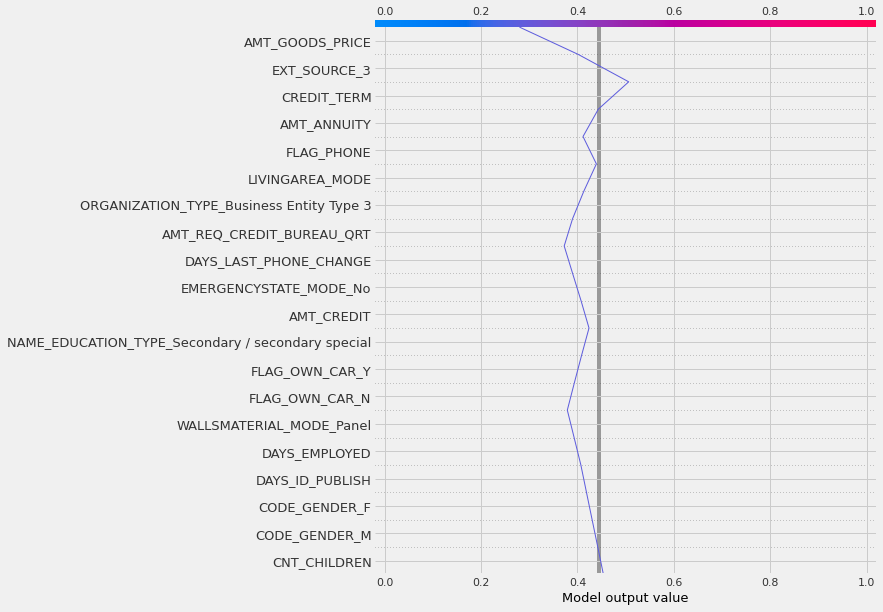

In [63]:
shap.decision_plot(expected_value_1, shap_values_1, feature_names=list(feature_names), link='logit')

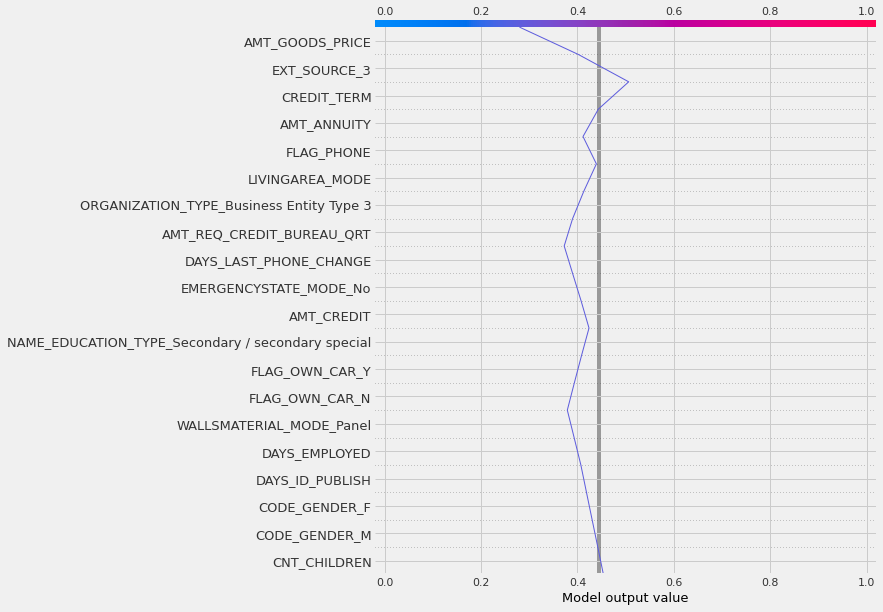

In [64]:
img_ind = shap.decision_plot(expected_value_1, shap_values_1, feature_names=list(feature_names), link='logit')

In [57]:
df_Client_Info = pd.read_csv(path + 'df_Client_Info.csv')

In [64]:
feature_names[feature_names=='ORGANIZATION_TYPE_Kindergarten']

Index(['ORGANIZATION_TYPE_Kindergarten'], dtype='object')